In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
import math
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle

In [6]:
test_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')
train_data = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')

In [7]:
train_data.shape

(1296675, 23)

In [8]:
test_data.shape

(555719, 23)

In [9]:
train_data = train_data.drop('Unnamed: 0', axis=1)
train_data = train_data.drop('trans_num', axis=1)
train_data = train_data.drop('first', axis=1)
train_data = train_data.drop('last', axis=1)
train_data = train_data.drop('street', axis=1)
train_data = train_data.drop('city', axis=1)

In [10]:
# calculating distance between credit card holder location and location of merchant
train_data['distance'] = np.sqrt((train_data['lat'] - train_data['merch_lat'])**2 + (train_data['long'] - train_data['merch_long'])**2)

In [11]:
# converting to date time
train_data['trans_date_trans_time'] = pd.to_datetime(train_data['trans_date_trans_time'])

In [12]:
# pulling the hour for a variable
def pull_hour(ts):
    return ts.hour
train_data['hour'] = train_data['trans_date_trans_time'].apply(pull_hour)

In [13]:
# using unix time we are going to calculate the sum of transaction amounts in past 30 days
# we will create two variables from this, first sum of transactions in 30 days
# next will be a interaction based variable between current purchase amount / 30 day total
# this will help measure if this transaction is out of the ordinary


# function to calculate last 30 day spending
def sum_30_day(unixtime, cc_num):
    unixstamp = unixtime
    minus30 = unixstamp - 2629743
    ccnum = cc_num
    sumtable = train_data.loc[(train_data["cc_num"] == ccnum) & (train_data['unix_time'] < unixstamp) & (train_data['unix_time'] > minus30)]
    history30 = sumtable['amt'].sum()
    return history30

    
# running function and creating a new variable for it
train_data['history_30'] = train_data.apply(lambda x: sum_30_day(x.unix_time, x.cc_num), axis=1)


# measuring interaction effect with amt in new variable
train_data['interaction_30'] = train_data['history_30'] / train_data['amt']

In [14]:
# dropping non categorical variables in preperation for regression modeling

train_data = train_data.drop('trans_date_trans_time', axis=1)
train_data = train_data.drop('state', axis=1)
train_data = train_data.drop('merchant', axis=1)
train_data = train_data.drop('job', axis=1)
train_data = train_data.drop('dob', axis=1)
train_data = train_data.drop('category', axis=1)
train_data = train_data.drop('gender', axis=1)

In [15]:
train_data.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,distance,hour,history_30,interaction_30
0,2703186189652095,4.97,28654,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0.872830,0,0.0,0.0
1,630423337322,107.23,99160,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0.272310,0,0.0,0.0
2,38859492057661,220.11,83252,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0.975845,0,0.0,0.0
3,3534093764340240,45.00,59632,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0.919802,0,0.0,0.0
4,375534208663984,41.96,24433,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0.868505,0,0.0,0.0


Text(0.5, 1.0, 'Correlation')

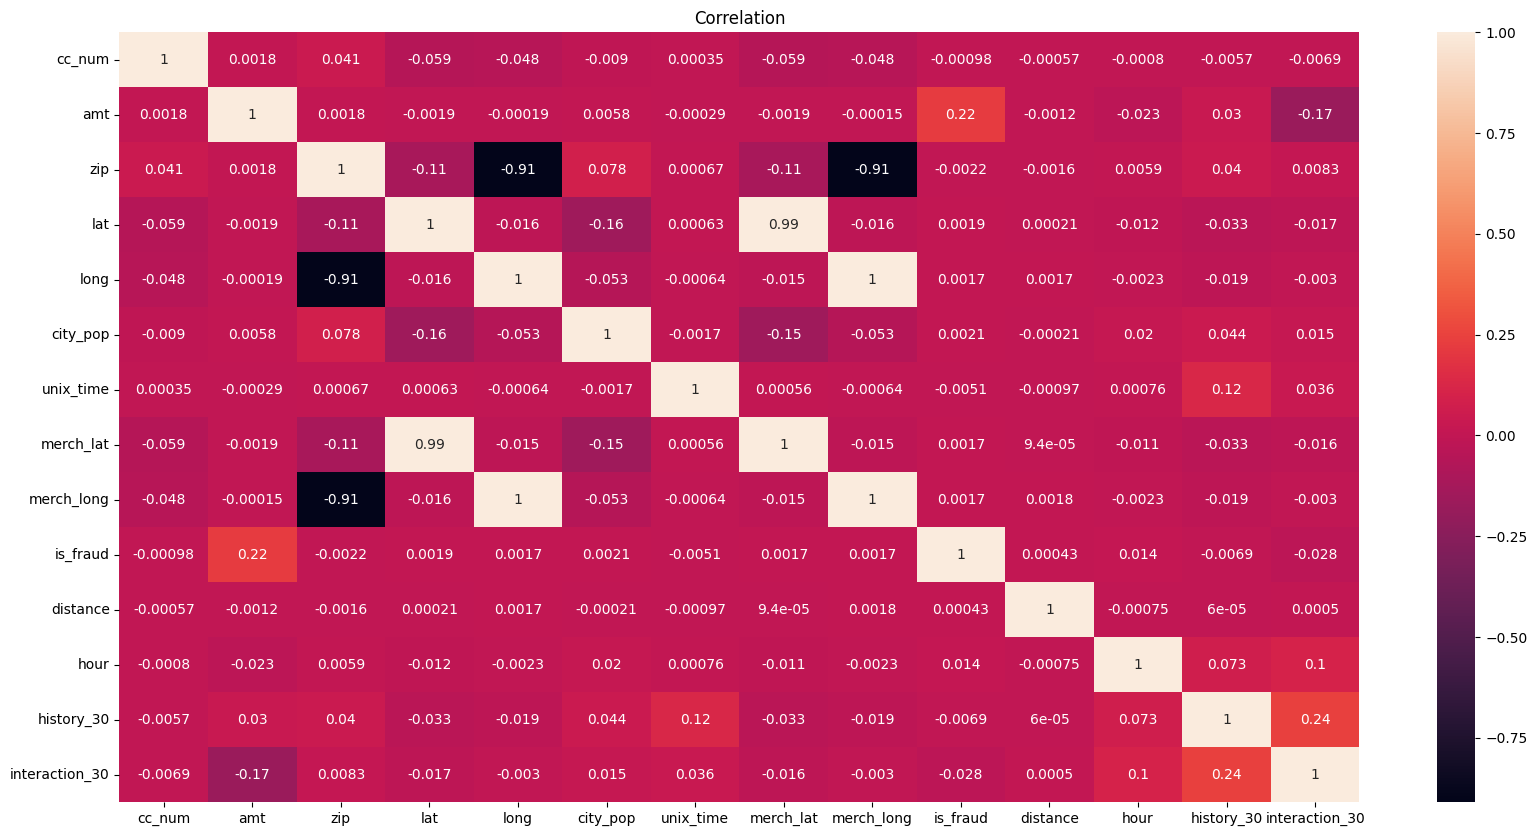

In [16]:
# creating a correlation heatmap
# using this we will check for any multicollinearity issues
# multicollinearity is when two variables have a correlation >0.7 with eachother


fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train_data.corr(),annot=True).set_title('Correlation')

In [17]:
# there is multicollinearity issues with our non generated predictors such as lat longs, we will drop all of these

train_data = train_data.drop('cc_num', axis=1)
train_data = train_data.drop('zip', axis=1)
train_data = train_data.drop('lat', axis=1)
train_data = train_data.drop('long', axis=1)
train_data = train_data.drop('unix_time', axis=1)
train_data = train_data.drop('merch_lat', axis=1)
train_data = train_data.drop('merch_long', axis=1)

In [18]:
train_data.head()

,amt,city_pop,is_fraud,distance,hour,history_30,interaction_30
0,4.97,3495,0,0.872830,0,0.0,0.0
1,107.23,149,0,0.272310,0,0.0,0.0
2,220.11,4154,0,0.975845,0,0.0,0.0
3,45.00,1939,0,0.919802,0,0.0,0.0
4,41.96,99,0,0.868505,0,0.0,0.0


Text(0.5, 1.0, 'Correlation')

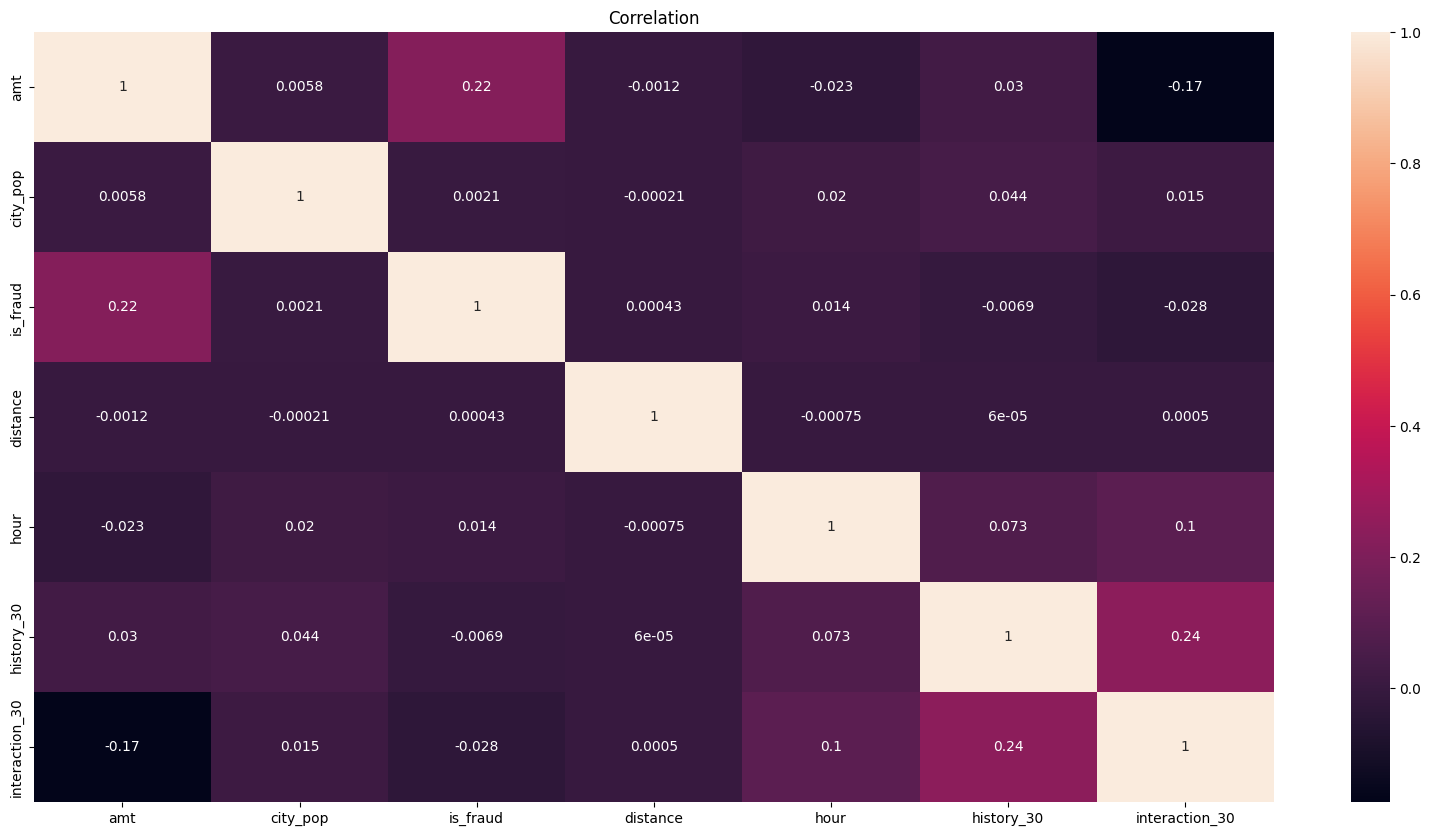

In [19]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(train_data.corr(),annot=True).set_title('Correlation')

In [20]:
# all the multicollinearity issues are fixed, we are going to begin our fitting process with the data

# we are going to use a logistic regression algorithim for this binary classification

# we will then measure using an accuracy score to see if our model is working

y = train_data['is_fraud']
x = train_data.drop('is_fraud', axis=1) 

np.save('x_train.npy', x)
np.save('y_train.npy', y)

x, y = shuffle(x, y, random_state=1)

model = LogisticRegression()
model.fit(x, y)



LogisticRegression()

In [35]:
import pickle

# Save the model to a file
filename = 'Credit_Card_Fraud_Detection_Model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [21]:
test_data = test_data.drop('Unnamed: 0', axis=1)
test_data = test_data.drop('trans_num', axis=1)
test_data = test_data.drop('first', axis=1)
test_data = test_data.drop('last', axis=1)
test_data = test_data.drop('street', axis=1)
test_data = test_data.drop('city', axis=1)

In [22]:
test_data['distance'] = np.sqrt((test_data['lat'] - test_data['merch_lat'])**2 + (test_data['long'] - test_data['merch_long'])**2)

In [23]:
test_data['trans_date_trans_time'] = pd.to_datetime(test_data['trans_date_trans_time'])

In [24]:
def pull_hour(ts):
    return ts.hour
test_data['hour'] = test_data['trans_date_trans_time'].apply(pull_hour)

In [25]:
def sum_30_day(unixtime, cc_num):
    unixstamp = unixtime
    minus30 = unixstamp - 2629743
    ccnum = cc_num
    sumtable = test_data.loc[(test_data["cc_num"] == ccnum) & (test_data['unix_time'] < unixstamp) & (test_data['unix_time'] > minus30)]
    history30 = sumtable['amt'].sum()
    return history30    
test_data['history_30'] = test_data.apply(lambda x: sum_30_day(x.unix_time, x.cc_num), axis=1)
test_data['interaction_30'] = test_data['history_30'] / test_data['amt']

In [29]:
train_data.head()

,amt,city_pop,is_fraud,distance,hour,history_30,interaction_30
0,4.97,3495,0,0.872830,0,0.0,0.0
1,107.23,149,0,0.272310,0,0.0,0.0
2,220.11,4154,0,0.975845,0,0.0,0.0
3,45.00,1939,0,0.919802,0,0.0,0.0
4,41.96,99,0,0.868505,0,0.0,0.0


In [28]:
test_data.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,distance,hour,history_30,interaction_30
0,2291163933867244,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0,0.266004,12,0.0,0.0
1,3573030041201292,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0,0.991674,12,0.0,0.0
2,3598215285024754,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0,0.682970,12,0.0,0.0
3,3591919803438423,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0,0.250985,12,0.0,0.0
4,3526826139003047,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0,1.118816,12,0.0,0.0


In [30]:
test_data = test_data.drop('cc_num', axis=1)
test_data = test_data.drop('zip', axis=1)
test_data = test_data.drop('lat', axis=1)
test_data = test_data.drop('long', axis=1)
test_data = test_data.drop('unix_time', axis=1)
test_data = test_data.drop('merch_lat', axis=1)
test_data = test_data.drop('merch_long', axis=1)

In [31]:
test_data.head()

,amt,city_pop,is_fraud,distance,hour,history_30,interaction_30
0,2.86,333497,0,0.266004,12,0.0,0.0
1,29.84,302,0,0.991674,12,0.0,0.0
2,41.28,34496,0,0.682970,12,0.0,0.0
3,60.05,54767,0,0.250985,12,0.0,0.0
4,3.19,1126,0,1.118816,12,0.0,0.0


In [32]:
y_test = test_data['is_fraud']
x_test = test_data.drop('is_fraud', axis=1) 

np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [33]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.9955157192753892
